# Level 3 VQ-VAE Run Script

## Import a bunch of packages

In [1]:
import IPython

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import yaml
import matplotlib.pyplot as plt
import torchaudio

from models.multi_level_vqvae import MultiLvlVQVariationalAutoEncoder
from loaders.music_loader import MP3SliceDataset
from loaders.lvl3_loader import Lvl3InputDataset
from loaders.lvl2_loader import Lvl2InputDataset
from utils.other import load_cfg_dict

## Load configuration files and add weights paths

In [2]:
config_path_lvl1 = "config/lvl1_config.yaml"
weights_path_lvl1 = "model_weights/lvl1_vqvae.ckpt"
cfg_1 = load_cfg_dict(config_path_lvl1)

config_path_lvl2 = "config/lvl2_config.yaml"
weights_path_lvl2 = "model_weights/lvl2_vqvae.ckpt"
cfg_2 = load_cfg_dict(config_path_lvl2)

config_path_lvl3 = "config/lvl3_config.yaml"
weights_path_lvl3 = "model_weights/lvl3_vqvae.ckpt"
cfg_3 = load_cfg_dict(config_path_lvl3)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Load the models

In [3]:
model_lvl1 = MultiLvlVQVariationalAutoEncoder.load_from_checkpoint(weights_path_lvl1, **cfg_1, strict=False).to(device)
model_lvl1.eval()

#model_lvl2 = MultiLvlVQVariationalAutoEncoder(**cfg_2).to(device)
model_lvl2 = MultiLvlVQVariationalAutoEncoder.load_from_checkpoint(weights_path_lvl2, **cfg_2).to(device)
model_lvl2.eval()

model_lvl3 = MultiLvlVQVariationalAutoEncoder.load_from_checkpoint(weights_path_lvl3, **cfg_3, strict=False).to(device)
model_lvl3.eval()

MultiLvlVQVariationalAutoEncoder(
  (encoder): Encoder1D(
    (activation): GELU()
    (init_conv): Conv1d(8, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv_list): ModuleList(
      (0): Res1DBlock(
        (res_block_modules): ModuleList(
          (0): Sequential(
            (0): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
            (1): GELU()
            (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (1): Sequential(
            (0): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(3,), dilation=(3,))
            (1): GELU()
            (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (2): Sequential(
            (0): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(9,), dilation=(9,))
            (1): GELU()
            (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         

### HTML wrapper to display sound clips:

In [4]:
# this is a wrapper that take a filename and publish an html <audio> tag to listen to it

def wavPlayer(filepath):
    """ will display html 5 player for compatible browser

    Parameters :
    ------------
    filepath : relative filepath with respect to the notebook directory ( where the .ipynb are not cwd)
               of the file to play

    The browser need to know how to play wav through html5.

    there is no autoplay to prevent file playing when the browser opens
    """
    
    src = """
    <head>
    <meta http-equiv="Content-Type" content="text/html; charset=utf-8">
    <title>Simple Test</title>
    </head>
    
    <body>
    <audio controls="controls" style="width:600px" >
      <source src="files/%s" type="audio/mp3" />
      Your browser does not support the audio element.
    </audio>
    </body>
    """%(filepath)
    display(HTML(src))

## Load a dataset sample and display it.

### Load the slice

Loading file data/music_samples/002-datatensor.pt...
Music file data/music_samples/002-datatensor.pt is loaded.
Loading file data/music_samples/002-metadata.pkl...
Music file data/music_samples/002-metadata.pkl is loaded.
Current track is data/music_samples/01 Infected Mushroom - Bust A Move (Bliss Remix).mp3
Loading file data/music_samples/001-datatensor.pt...
Music file data/music_samples/001-datatensor.pt is loaded.
Loading file data/music_samples/001-metadata.pkl...
Music file data/music_samples/001-metadata.pkl is loaded.
Loading file data/music_samples/000-datatensor.pt...
Music file data/music_samples/000-datatensor.pt is loaded.
Loading file data/music_samples/000-metadata.pkl...
Music file data/music_samples/000-metadata.pkl is loaded.


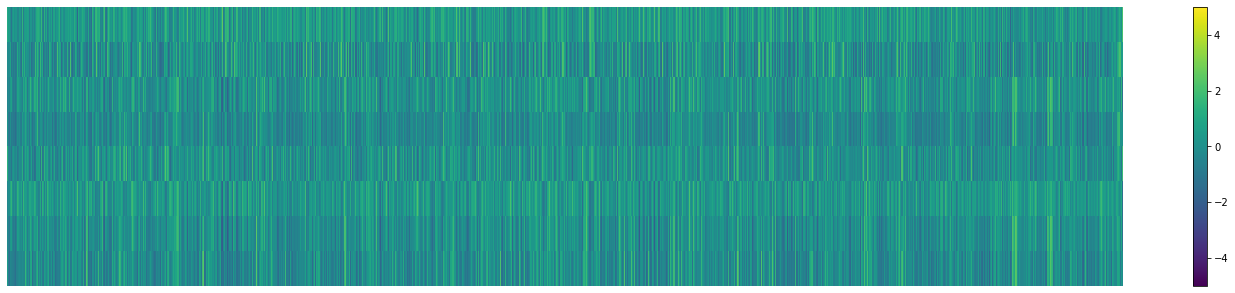

In [5]:
dataset = Lvl3InputDataset(preload=True)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
for sample in dataloader:
    lvl3_sample = sample['music slice'].squeeze(0)
    print(f"Current track is {sample['track name'][0]}")
    break

dataset_lvl2 = Lvl2InputDataset(preload=True)
dataloader = DataLoader(dataset_lvl2, batch_size=1, shuffle=True)
for sample in dataloader:
    lvl2_sample = sample['music slice'].squeeze(0)
    break

dataset_lvl1 = MP3SliceDataset(preload=True)
dataloader = DataLoader(dataset_lvl1, batch_size=1, shuffle=True)
for sample in dataloader:
    lvl1_sample = sample['music slice'].squeeze(0)
    break

plt.figure(figsize=(25, 5))
plt.matshow(lvl3_sample.cpu().detach().numpy(), fignum=1, aspect='auto', vmin=-5.0, vmax=5.0)
plt.colorbar()
plt.axis('off')
plt.show()

## Run the level 3 network and show results

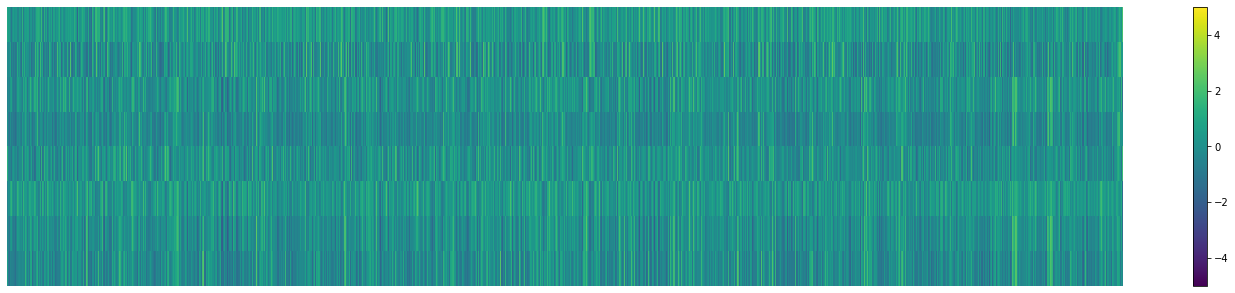

torch.Size([8, 4096]) torch.Size([8, 4096])


In [6]:
lvl3_output = model_lvl3(lvl3_sample.clone().unsqueeze(0).to(device))
with torch.no_grad():
    lvl2_pred = lvl3_output['output'][0]
plt.figure(figsize=(25, 5))
plt.matshow(lvl2_pred.cpu().detach().numpy(), fignum=1, aspect='auto', vmin=-5.0, vmax=5.0)
plt.colorbar()
plt.axis('off')
plt.show()
print(lvl2_pred.size(), lvl3_sample.size())

## Show the subtraction between the ground truth and the reconstruction

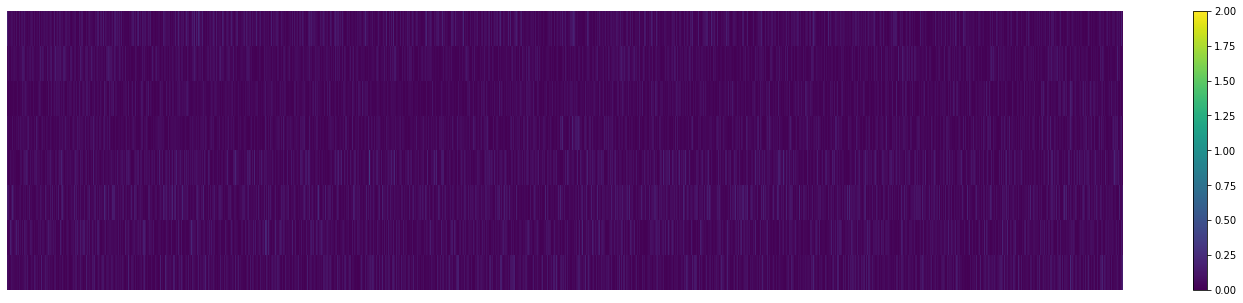

In [7]:
plt.figure(figsize=(25, 5))
plt.matshow(torch.abs(lvl3_sample.cpu() - lvl2_pred.cpu()).detach().numpy(), fignum=1, aspect='auto', vmin=0, vmax=2.0)
plt.colorbar()
plt.axis('off')
plt.show()

## Pass the level 2 outputs through the level 1 decoder and make MUSIC!

### Sanity Check, reconstruction of the lvl1 data

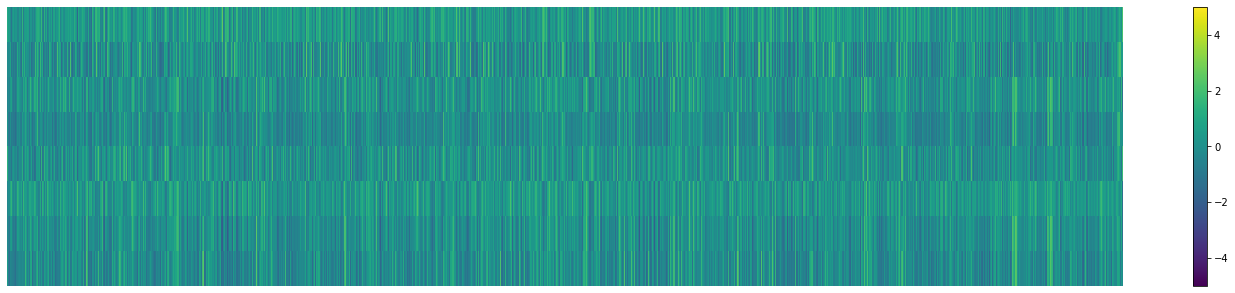

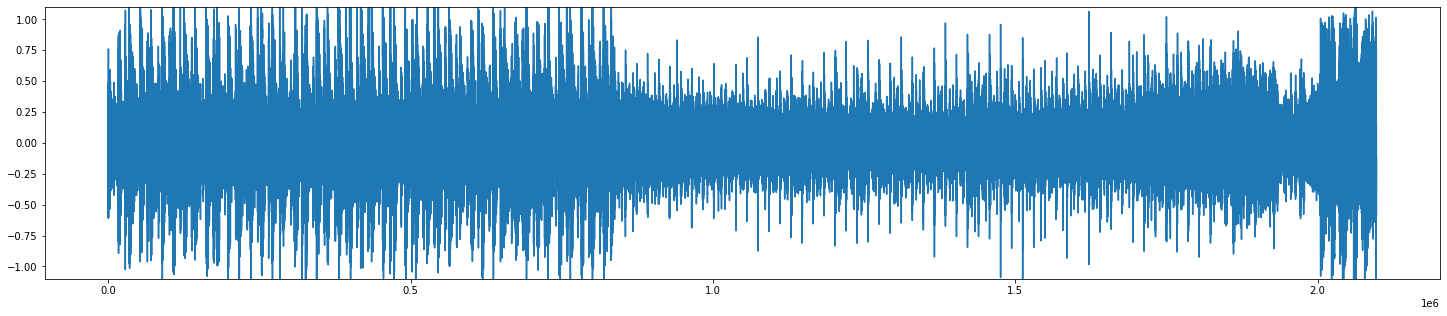

In [9]:
from torch.utils.data import TensorDataset, DataLoader

batch_divide = 8
batch_size = 4

with torch.no_grad():
    # z_q_out = vq_input
    lvl3_sample_divided = lvl3_sample.unsqueeze(0).permute((0, 2, 1)).reshape((batch_divide, -1, cfg_2['latent_depth'])).permute((0, 2, 1))
    
    plt.figure(figsize=(25, 5))
    plt.matshow(lvl3_sample[:, :].squeeze(0).cpu().detach().numpy(), fignum=1, aspect='auto', vmin=-5, vmax=5.0)
    plt.colorbar()
    plt.axis('off')
    plt.show()
    
    lvl3_dataset = TensorDataset(lvl3_sample_divided)
    lvl3_dataloader = DataLoader(lvl3_dataset, batch_size=batch_size)
    
    output_lvl1 = torch.zeros([1, cfg_1['input_channels'], 0]).to(device=device)
    
    for lvl3_ind_sample in lvl3_dataloader:

        output_lvl2, _ = model_lvl2.decode(lvl3_ind_sample[0].to(device))
        output_lvl2 = output_lvl2.permute((0, 2, 1)).reshape((batch_divide * batch_size, -1, cfg_1['latent_depth'])).permute((0, 2, 1))
        
        lvl2_dataset = TensorDataset(output_lvl2)
        lvl2_dataloader = DataLoader(lvl2_dataset, batch_size=batch_size)
        
        for lvl2_ind_sample in lvl2_dataloader:
            
            output_lvl1_ind, _ = model_lvl1.decode(lvl2_ind_sample[0].to(device))
            output_lvl1_ind = output_lvl1_ind.permute((0, 2, 1)).reshape((1, -1, 1)).permute((0, 2, 1))
            output_lvl1 = torch.cat((output_lvl1, output_lvl1_ind), dim=2)
    
music_sample_rec = output_lvl1.view((1, -1))
plt.figure(figsize=(25, 5))
plt.plot(music_sample_rec[0, ...].cpu().detach().numpy())
plt.ylim((-1.1, 1.1))
plt.show()
torchaudio.save('sample_out.mp3', music_sample_rec.cpu().detach(), 44100, format='mp3')
IPython.display.Audio(filename="sample_out.mp3")

### CREATE MUSIC!!!

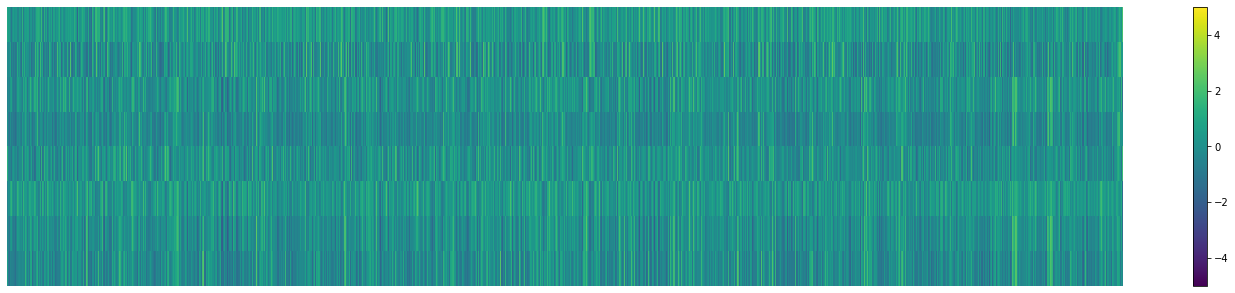

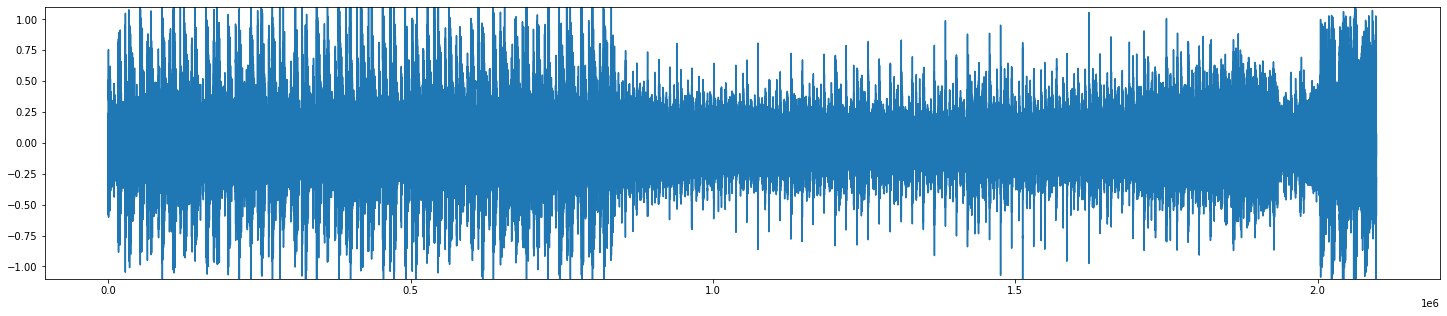

In [10]:
batch_divide = 8
batch_size = 4

with torch.no_grad():

    # z_q_out = vq_input
    lvl3_sample_divided = lvl2_pred.unsqueeze(0).permute((0, 2, 1)).reshape((batch_divide, -1, cfg_2['latent_depth'])).permute((0, 2, 1))
    
    plt.figure(figsize=(25, 5))
    plt.matshow(lvl2_pred[:, :].squeeze(0).cpu().detach().numpy(), fignum=1, aspect='auto', vmin=-5, vmax=5.0)
    plt.colorbar()
    plt.axis('off')
    plt.show()
    
    lvl3_dataset = TensorDataset(lvl3_sample_divided)
    lvl3_dataloader = DataLoader(lvl3_dataset, batch_size=batch_size)
    
    output_lvl1 = torch.zeros([1, cfg_1['input_channels'], 0]).to(device=device)
    
    for lvl3_ind_sample in lvl3_dataloader:

        output_lvl2, _ = model_lvl2.decode(lvl3_ind_sample[0].to(device))
        output_lvl2 = output_lvl2.permute((0, 2, 1)).reshape((batch_divide * batch_size, -1, cfg_1['latent_depth'])).permute((0, 2, 1))
        
        lvl2_dataset = TensorDataset(output_lvl2)
        lvl2_dataloader = DataLoader(lvl2_dataset, batch_size=batch_size)
        
        for lvl2_ind_sample in lvl2_dataloader:
            
            output_lvl1_ind, _ = model_lvl1.decode(lvl2_ind_sample[0].to(device))
            output_lvl1_ind = output_lvl1_ind.permute((0, 2, 1)).reshape((1, -1, 1)).permute((0, 2, 1))
            output_lvl1 = torch.cat((output_lvl1, output_lvl1_ind), dim=2)
    
music_sample_rec = output_lvl1.view((1, -1))
plt.figure(figsize=(25, 5))
plt.plot(music_sample_rec[0, ...].cpu().detach().numpy())
plt.ylim((-1.1, 1.1))
plt.show()
torchaudio.save('sample_out.mp3', music_sample_rec.cpu().detach(), 44100, format='mp3')
IPython.display.Audio(filename="sample_out.mp3")